C:\Users\WANG-\AppData\Local\Temp\ipykernel_28760\601814517.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequent_paragraphs_df['Classification'] = frequent_paragraphs_df['Paragraph'].apply(classify_paragraph_lvmh)
C:\Users\WANG-\AppData\Local\Temp\ipykernel_28760\601814517.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequent_paragraphs_df[category] = False
C:\Users\WANG-\AppData\Local\Temp\ipykernel_28760\601814517.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

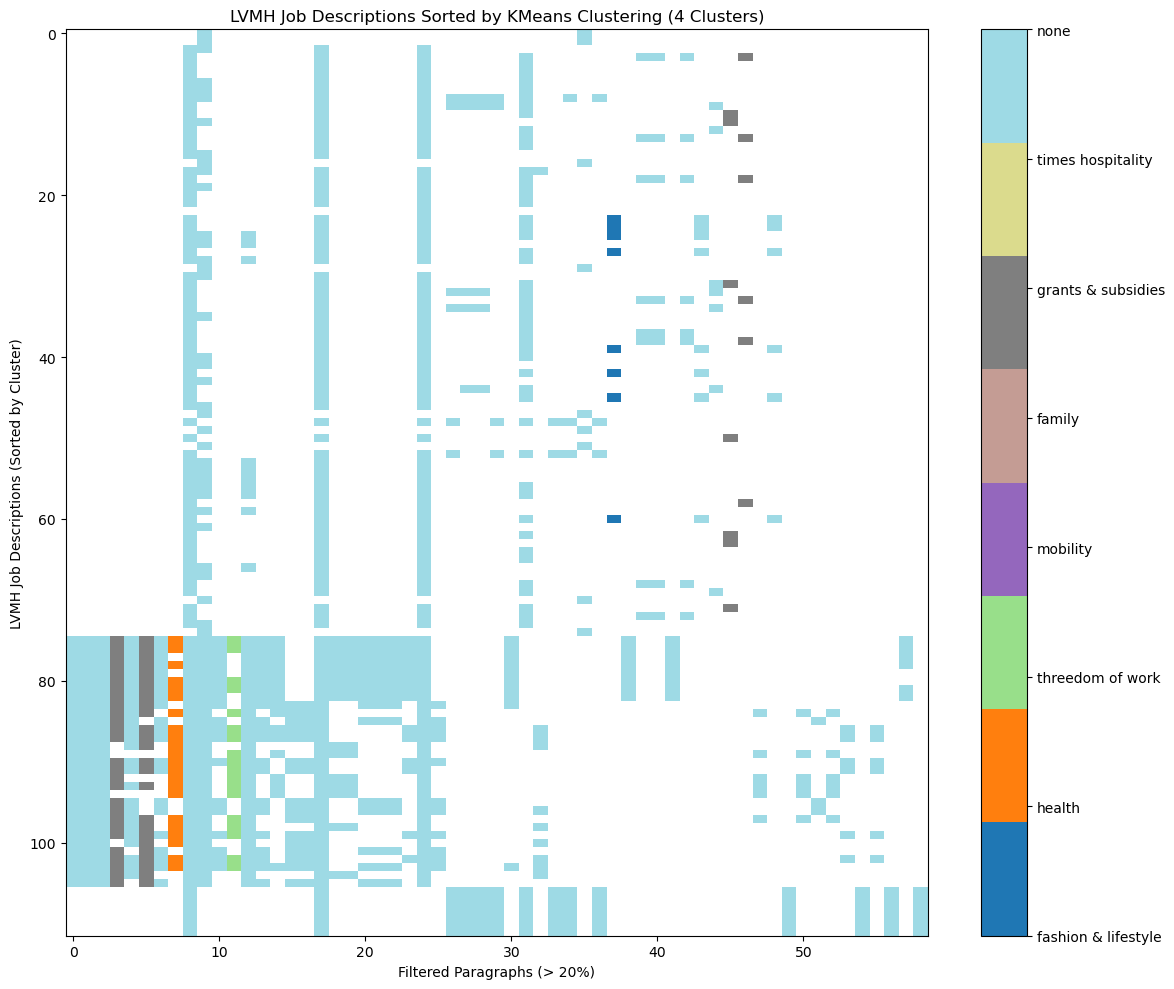

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re
from collections import Counter

# Load the LVMH job descriptions CSV (replace with the actual file paths)
lvmh_job_desc_file = 'lvmh_merged_output.csv'

# Read the file
lvmh_df = pd.read_csv(lvmh_job_desc_file)

# Combine the 'Job Responsibilities', 'Profile', and 'Additional Information' into a new 'Job Description' column
lvmh_df['Job Description'] = (
    lvmh_df['Job Responsibilities'].fillna('') + ' ' + 
    lvmh_df['Profile'].fillna('') + ' ' + 
    lvmh_df['Additional Information'].fillna('')
).str.strip()

# Clean the "Job Description" column and prepare it for frequency analysis
lvmh_df['Job Description'] = lvmh_df['Job Description'].str.replace('\r\n', ' ').str.strip()

# Split the job descriptions into sentences/paragraphs and count the frequency
all_lvmh_paragraphs = []
for details in lvmh_df['Job Description']:
    paragraphs = re.split(r'[.!\n]', details)
    paragraphs = [para.strip() for para in paragraphs if para.strip()]  # Remove empty and whitespace-only strings
    all_lvmh_paragraphs.extend(paragraphs)

# Count the frequency of each unique paragraph
lvmh_paragraph_freq = Counter(all_lvmh_paragraphs)
lvmh_paragraph_freq_df = pd.DataFrame(lvmh_paragraph_freq.items(), columns=['Paragraph', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Filter paragraphs that appear more than 20% of the total jobs
threshold = 0.05 * len(lvmh_df)
frequent_paragraphs_df = lvmh_paragraph_freq_df[lvmh_paragraph_freq_df['Frequency'] > threshold]

# Define categories for classification
lvmh_categories = [
    'fashion & lifestyle', 
    'health', 
    'threedom of work', 
    'mobility', 
    'family',  
    'grants & subsidies', 
    'times hospitality', 
    'none'
]

# Define a function to classify paragraphs based on analysis
def classify_paragraph_lvmh(paragraph):
    """Classify the paragraph into one of the eight categories based on content analysis."""
    paragraph = paragraph.lower()
    if 'fashion' in paragraph or 'lifestyle' in paragraph:
        return 'fashion & lifestyle'
    elif 'health' in paragraph or 'well-being' in paragraph:
        return 'health'
    elif 'freedom' in paragraph or 'work' in paragraph:
        return 'threedom of work'
    elif 'mobility' in paragraph or 'transport' in paragraph:
        return 'mobility'
    elif 'family' in paragraph or 'parents' in paragraph:
        return 'family'
    elif 'grants' in paragraph or 'subsidies' in paragraph:
        return 'grants & subsidies'
    elif 'hospitality' in paragraph or 'times' in paragraph:
        return 'times hospitality'
    else:
        return 'none'

# Apply the classification to frequent paragraphs
frequent_paragraphs_df['Classification'] = frequent_paragraphs_df['Paragraph'].apply(classify_paragraph_lvmh)


# Initialize the classification columns with False values
for category in lvmh_categories:
    frequent_paragraphs_df[category] = False

# Set the appropriate category to True based on the classified result
for index, row in frequent_paragraphs_df.iterrows():
    classification = row['Classification']
    if classification in lvmh_categories:
        frequent_paragraphs_df.at[index, classification] = True

# Remove the temporary classification column
frequent_paragraphs_df = frequent_paragraphs_df.drop(columns=['Classification'])

# Save the result as a CSV for further use
output_lvmh_file_path = 'lvmh_classified_paragraphs.csv'
frequent_paragraphs_df.to_csv(output_lvmh_file_path, index=False)

frequent_paragraphs_df= pd.read_csv('lvmh_classified_paragraphs_byhand.csv')
# Convert classified paragraphs into a matrix for the heatmap
lvmh_job_paragraphs_matrix = np.full((len(lvmh_df), len(frequent_paragraphs_df)), np.nan)

for i, details in enumerate(lvmh_df['Job Description']):
    for j, paragraph in enumerate(frequent_paragraphs_df['Paragraph']):
        if paragraph in details:
            row = frequent_paragraphs_df.iloc[j]
            class_color = 'none'  # Default to none/gray
            for category in lvmh_categories:
                if row[category]:  # Check for True values in classification columns
                    class_color = category
                    break
            lvmh_job_paragraphs_matrix[i, j] = lvmh_categories.index(class_color)

# Apply KMeans clustering to the LVMH job descriptions based on the paragraph occurrences
kmeans = KMeans(n_clusters=4, random_state=42)
lvmh_job_clusters = kmeans.fit_predict(np.nan_to_num(lvmh_job_paragraphs_matrix))  # Convert NaN to 0 for clustering

# Add the cluster labels to the dataframe for sorting
lvmh_df['Cluster'] = lvmh_job_clusters

# Sort the job descriptions based on their assigned cluster
sorted_lvmh_df = lvmh_df.sort_values(by='Cluster').reset_index(drop=True)

# Recreate the matrix for the heatmap, sorted by clusters
sorted_lvmh_job_paragraphs_matrix = np.full((len(sorted_lvmh_df), len(frequent_paragraphs_df)), np.nan)

for i, details in enumerate(sorted_lvmh_df['Job Description']):
    for j, paragraph in enumerate(frequent_paragraphs_df['Paragraph']):
        if paragraph in details:
            row = frequent_paragraphs_df.iloc[j]
            class_color = 'none'  # Default to none/gray
            for category in lvmh_categories:
                if row[category]:  # Check for True values in classification columns
                    class_color = category
                    break
            sorted_lvmh_job_paragraphs_matrix[i, j] = lvmh_categories.index(class_color)

# Plot the heatmap with jobs sorted by cluster
plt.figure(figsize=(12, 10))
cmap = plt.cm.get_cmap('tab20', len(lvmh_categories))
cmap.set_bad(color='white')  # Set white for missing values (NaN)

plt.imshow(sorted_lvmh_job_paragraphs_matrix, cmap=cmap, aspect='auto')

# Create a colorbar with class labels
class_labels_for_colorbar = lvmh_categories + ['None']
cbar = plt.colorbar(ticks=range(len(class_labels_for_colorbar)))
cbar.ax.set_yticklabels(class_labels_for_colorbar)

# Label the axes
plt.xlabel('Filtered Paragraphs (> 20%)')
plt.ylabel('LVMH Job Descriptions (Sorted by Cluster)')
plt.title('LVMH Job Descriptions Sorted by KMeans Clustering (4 Clusters)')

plt.tight_layout()
plt.show()


C:\Users\WANG-\AppData\Local\Temp\ipykernel_28760\572908873.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(lvmh_categories))


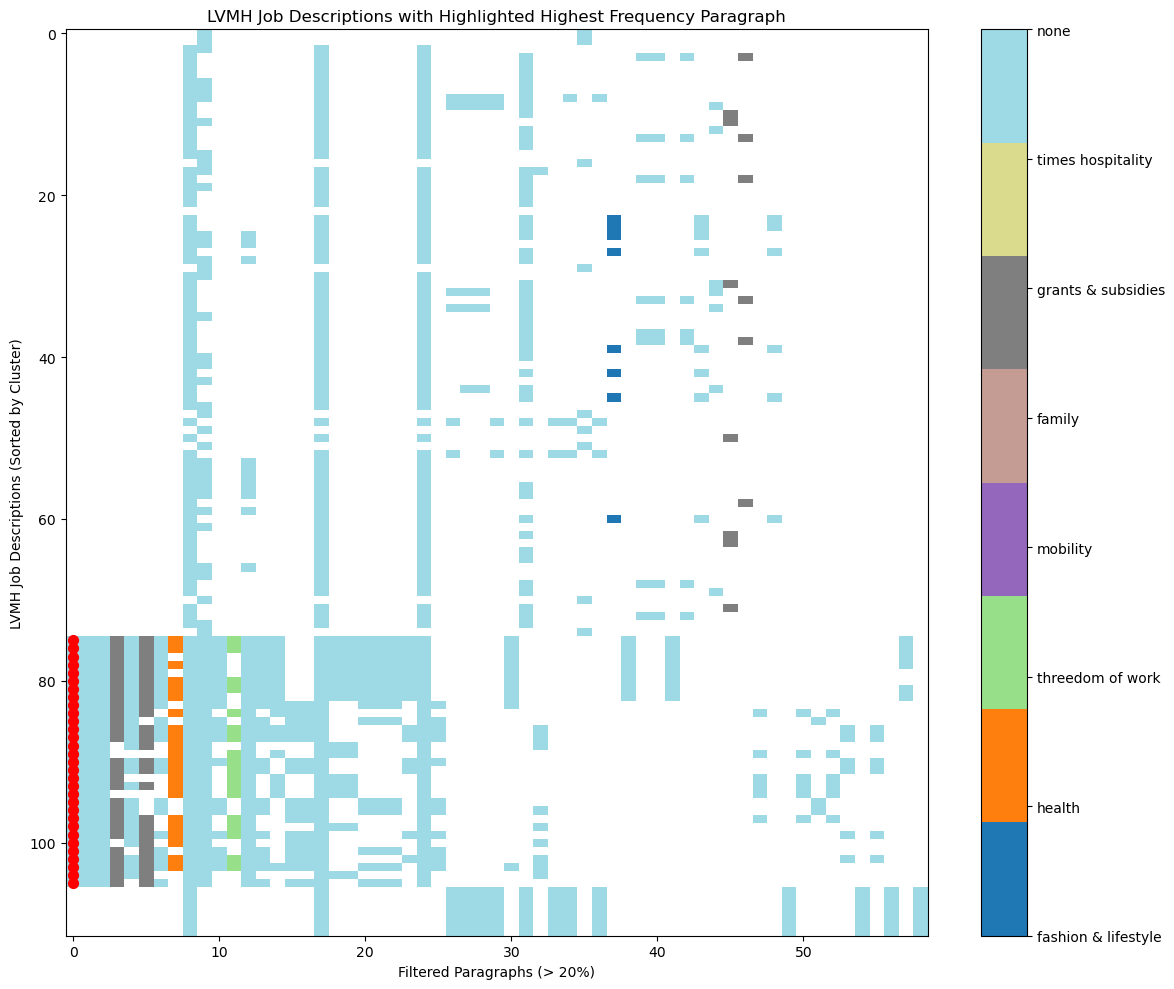

[0,
 1,
 2,
 5,
 16,
 21,
 32,
 37,
 38,
 40,
 61,
 64,
 65,
 68,
 79,
 80,
 81,
 82,
 83,
 84,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 101,
 102,
 106,
 107]

In [2]:
# Step 1: Find the paragraph with the highest frequency from frequent_paragraphs_df
highest_frequency_paragraph = frequent_paragraphs_df.loc[frequent_paragraphs_df['Frequency'].idxmax()]

highest_paragraph_text = highest_frequency_paragraph['Paragraph']
highest_paragraph_frequency = highest_frequency_paragraph['Frequency']

# Step 2: Add a marker to the heatmap to indicate the highest frequency paragraph position
# Find the index of the highest frequency paragraph in frequent_paragraphs_df
highest_paragraph_index = frequent_paragraphs_df.index.get_loc(frequent_paragraphs_df['Frequency'].idxmax())

# Create a list to hold the positions where the highest frequency paragraph appears
positions_highest_paragraph = []

# Mark the occurrence of the highest frequency paragraph in the sorted heatmap matrix
for i, details in enumerate(sorted_lvmh_df['Job Description']):
    if highest_paragraph_text in details:
        positions_highest_paragraph.append((i, highest_paragraph_index))

# Step 3: Find which job descriptions contain the highest frequency paragraph
jobs_with_highest_paragraph = lvmh_df[lvmh_df['Job Description'].str.contains(highest_paragraph_text, na=False)]

# Display the job titles or indices where the highest frequency paragraph appears
jobs_with_highest_paragraph_list = jobs_with_highest_paragraph.index.tolist()

# Plot the heatmap with jobs sorted by cluster
plt.figure(figsize=(12, 10))
cmap = plt.cm.get_cmap('tab20', len(lvmh_categories))
cmap.set_bad(color='white')  # Set white for missing values (NaN)

plt.imshow(sorted_lvmh_job_paragraphs_matrix, cmap=cmap, aspect='auto')

# Create a colorbar with class labels
class_labels_for_colorbar = lvmh_categories + ['none']
cbar = plt.colorbar(ticks=range(len(class_labels_for_colorbar)))
cbar.ax.set_yticklabels(class_labels_for_colorbar)

# Add markers for the highest frequency paragraph
for pos in positions_highest_paragraph:
    plt.scatter(pos[1], pos[0], marker='o', color='red', s=50, label='Highest Frequency Paragraph')

# Add labels and title
plt.xlabel('Filtered Paragraphs (> 20%)')
plt.ylabel('LVMH Job Descriptions (Sorted by Cluster)')
plt.title('LVMH Job Descriptions with Highlighted Highest Frequency Paragraph')

plt.tight_layout()
plt.show()

# Output the job descriptions containing the highest frequency paragraph
jobs_with_highest_paragraph_list


In [3]:
# Step 3: Find the job titles that contain the highest frequency paragraph
jobs_with_highest_paragraph_titles = jobs_with_highest_paragraph['Job Title'].tolist()


jobs_with_highest_paragraph = lvmh_df[lvmh_df['Job Title'].str.contains(highest_paragraph_text, na=False)]

# Get the "Job Title" for the indices that contain the highest frequency paragraph
jobs_with_highest_paragraph_titles = lvmh_df.loc[jobs_with_highest_paragraph_list, 'Job Title'].tolist()

# Output the job titles containing the highest frequency paragraph
jobs_with_highest_paragraph_titles

['BEAUTY CONSULTANT (M/W/X) HAMBURG',
 'Stock Room Expert (m/w/x) Berlin AlexanderplatzSephoraReference: 227305',
 'Stock Room Expert (m/w/x) KölnSephoraReference: 249601',
 'Beauty Consultant (m/w/x) SulzbachSephoraReference: 231738',
 'Stock Room Expert (m/w/x) Hamburg ÜberseequatierSephoraReference: 252059',
 'MAKE UP ARTIST (M/W/X) HAMBURG',
 'Make up Artist (m/w/x) MünchenSephoraReference: 256293',
 'Aushilfe (m/w/x) MünchenSephoraReference: 256171',
 'Assistant Corner Manager (m/w/x) MünchenSephoraReference: 236573',
 'Working Student (m/w/x) MünchenSephoraReference: 256172',
 'Assistant Store Manager (m/w/x) KölnSephoraReference: 220984',
 'Aushilfe (m/w/d) HannoverSephoraReference: 255192',
 'Aushilfe (m/w/d) DresdenSephoraReference: 250216',
 'Assistant Corner Manager (m/w/x) Berlin AlexSephoraReference: 246847',
 'Working Student (m/w/x) SulzbachSephoraReference: 237770',
 'Make Up Artist (m/w/x) SulzbachSephoraReference: 237771',
 'Make Up Artist (m/w/x) OberhausenSephoraRef

In [4]:
# Perform a word frequency analysis on the job titles that contain the highest frequency paragraph
all_titles_text = ' '.join(jobs_with_highest_paragraph_titles)
words = re.findall(r'\w+', all_titles_text.lower())  # Extract all words and convert to lowercase

# Count the frequency of each word
word_freq = Counter(words)

# Convert to DataFrame for easier visualization and analysis
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the top 10 most frequent words
word_freq_df.head(10)

,Word,Frequency
2,m,31
3,w,31
4,x,28
0,beauty,10
1,consultant,10
8,expert,6
25,assistant,6
27,manager,6
21,münchensephorareference,5
9,berlin,5
